Episode 0, Total Reward: -80, Exploration Rate: 0.298

Optimal Policy:
R D L U D
L X D U R
L X R D D
D X D D D
R R R R U

Testing trained agent:
State: (4, 0), Action: right, Reward: -1
State: (4, 1), Action: right, Reward: -1
State: (4, 2), Action: right, Reward: -1
State: (4, 3), Action: right, Reward: 5
Total test reward: 2


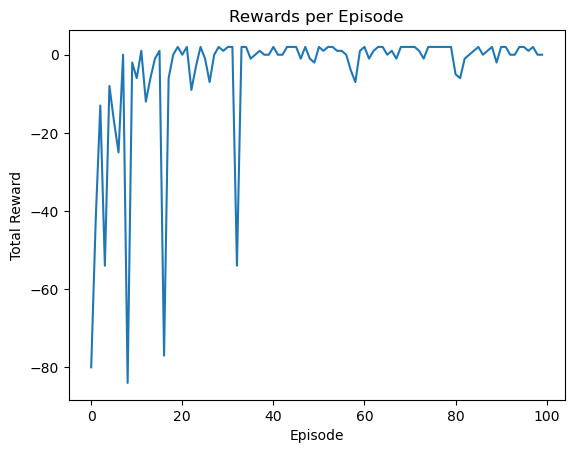

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

class GridWorld:
    """GridWorld environment with obstacles, rewards, and terminal states"""
    
    def __init__(self, size=5):
        self.size = size
        self.actions = ['up', 'down', 'left', 'right']
        self.n_actions = len(self.actions)
        
        # Define the grid: 0=empty, -1=obstacle, 1=reward, 2=terminal
        self.grid = np.zeros((size, size))
        
        # Set obstacles
        self.grid[1:4, 1] = -1
        
        # Set reward
        self.grid[0, 4] = 10
        
        # Set terminal state
        self.grid[4, 4] = 2
        
        # Define start position
        self.start_pos = (4, 0)
        self.current_pos = self.start_pos
        
    def reset(self):
        """Reset the environment to the start state"""
        self.current_pos = self.start_pos
        return self.current_pos
    
    def step(self, action):
        """Take a step in the environment"""
        row, col = self.current_pos
        
        if action == 'up' and row > 0:
            row -= 1
        elif action == 'down' and row < self.size - 1:
            row += 1
        elif action == 'left' and col > 0:
            col -= 1
        elif action == 'right' and col < self.size - 1:
            col += 1
            
        # Check if the new position is valid (not an obstacle)
        if self.grid[row, col] != -1:
            self.current_pos = (row, col)
        
        # Check if we've reached a terminal state
        done = (self.grid[row, col] == 2)
        
        # Calculate reward
        if self.grid[row, col] == 1:  # Reward cell
            reward = 10
        elif self.grid[row, col] == 2:  # Terminal cell
            reward = 5
        else:  # Regular cell
            reward = -1  # Small penalty for each move to encourage efficiency
            
        return self.current_pos, reward, done
    
    def render(self):
        """Visualize the gridworld"""
        grid_display = np.zeros((self.size, self.size))
        for i in range(self.size):
            for j in range(self.size):
                if self.grid[i, j] == -1:
                    grid_display[i, j] = -1  # Obstacle
                elif self.grid[i, j] == 1:
                    grid_display[i, j] = 1  # Reward
                elif self.grid[i, j] == 2:
                    grid_display[i, j] = 2  # Terminal
                else:
                    grid_display[i, j] = 0  # Empty
        
        # Mark the agent's position
        agent_pos = self.current_pos
        grid_display[agent_pos] = 0.5  # Agent
        
        plt.imshow(grid_display, cmap='viridis')
        plt.title("GridWorld")
        plt.show()

class QLearningAgent:
    """Q-learning agent for the GridWorld environment"""
    
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.3):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((env.size, env.size, env.n_actions))
    
    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.random() < self.exploration_rate:
            # Explore: random action
            return np.random.choice(self.env.actions)
        else:
            # Exploit: best action from Q-table
            row, col = state
            action_idx = np.argmax(self.q_table[row, col])
            return self.env.actions[action_idx]
    
    def update_q_table(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning update rule"""
        row, col = state
        next_row, next_col = next_state
        action_idx = self.env.actions.index(action)
        
        # Current Q-value
        current_q = self.q_table[row, col, action_idx]
        
        # Maximum Q-value for next state
        max_next_q = np.max(self.q_table[next_row, next_col])
        
        # Q-learning update
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[row, col, action_idx] = new_q
    
    def train(self, episodes=1000):
        """Train the agent for a number of episodes"""
        rewards = []
        
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward
            
            rewards.append(total_reward)
            
            # Decay exploration rate
            self.exploration_rate = max(0.01, self.exploration_rate * 0.995)
            
            if episode % 100 == 0:
                print(f"Episode {episode}, Total Reward: {total_reward}, Exploration Rate: {self.exploration_rate:.3f}")
        
        return rewards
    
    def get_optimal_policy(self):
        """Extract the optimal policy from the Q-table"""
        policy = np.empty((self.env.size, self.env.size), dtype=object)
        
        for i in range(self.env.size):
            for j in range(self.env.size):
                if self.env.grid[i, j] == -1:  # Obstacle
                    policy[i, j] = "X"
                else:
                    action_idx = np.argmax(self.q_table[i, j])
                    policy[i, j] = self.env.actions[action_idx][0].upper()  # First letter
        
        return policy

# Create environment and agent
env = GridWorld()
agent = QLearningAgent(env)

# Train the agent
rewards = agent.train(episodes=100)

# Display the learned policy
policy = agent.get_optimal_policy()
print("\nOptimal Policy:")
for row in policy:
    print(" ".join(row))

# Test the trained agent
state = env.reset()
done = False
total_reward = 0

print("\nTesting trained agent:")
while not done:
    action = agent.choose_action(state)  # Note: exploration rate is now very low
    next_state, reward, done = env.step(action)
    print(f"State: {state}, Action: {action}, Reward: {reward}")
    state = next_state
    total_reward += reward

print(f"Total test reward: {total_reward}")

# Plot the training progress
plt.plot(rewards)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()